## Kaggle Planet challenge - multiple label image classification 


## Problem
https://www.kaggle.com/c/planet-understanding-the-amazon-from-space


In [33]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [34]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [35]:
PATH = "data/planet/"
print(torch.cuda.is_available())
print(torch.backends.cudnn.enabled)
#assign GPU device
torch.cuda.set_device(0)

True
True


In [36]:
print(os.listdir(f'{PATH}'))
samplefiles=os.listdir(f'{PATH}train-jpg')[:5]
samplefiles

['test-jpg', 'train-jpg', 'train_v2.csv', 'models', 'tmp', 'test_v2_file_mapping.csv']


['train_2790.jpg',
 'train_34826.jpg',
 'train_9097.jpg',
 'train_36359.jpg',
 'train_33939.jpg']

(256, 256, 4)


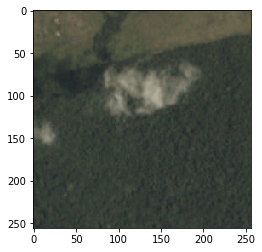

In [37]:
img = plt.imread(f'{PATH}train-jpg/{samplefiles[0]}')
plt.imshow(img)
print(img.shape)

In [38]:
#data
print(len(os.listdir(f'{PATH}train-jpg')))
print(len(os.listdir(f'{PATH}test-jpg')))

40479
40669


## Create validation set

In [39]:
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv))) - 1 # header is not counted (-1)
val_idxs = get_cv_idxs(n) # random 20% data for validation set
print('total: %s   cv: %s ' % (n,len(val_idxs)))

total: 40479   cv: 8095 


In [40]:
#F score function implemented in plant.py
from planet import f2
metrics=[f2]
arch = resnet34

In [41]:
def get_data(sz):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg')

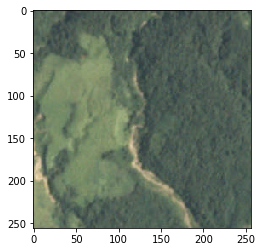

In [42]:
data = get_data(256)
x,y = next(iter(data.val_dl))
plt.imshow(data.val_ds.denorm(to_np(x))[0]*1.4);

In [43]:
sz=64
data = get_data(sz)
data = data.resize(int(sz*1.3), 'tmp')
learn = ConvLearner.pretrained(arch, data, metrics=metrics)

## Steps to build world class imageclassifier
1. precompute=True
1. Use `lr_find()` to find highest learning rate where loss is still clearly improving
1. Train last layer from precomputed activations for 1-2 epochs
1. Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1
1. Unfreeze all layers
1. Set earlier layers to 3x-10x lower learning rate than next higher layer
1. Use `lr_find()` again
1. Train full network with cycle_mult=2 until over-fitting



## Quick model:
1. No data augumentation. Use precompute=True to keep all weights except the last layer
2. Use LR finder to get the learning rate
3. Get a quick result for training/validation loss and accuracy

epoch      trn_loss   val_loss   f2                          
    0      0.217547   0.288528   0.791443  



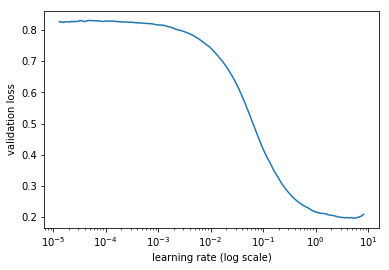

In [44]:
lrf=learn.lr_find()
learn.sched.plot()

In [45]:
lr=0.1
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.153671   0.137411   0.879497  
    1      0.145411   0.129463   0.888416                    
    2      0.140517   0.128081   0.890576                    
    3      0.138709   0.125787   0.892107                    
    4      0.135788   0.124421   0.892757                    
    5      0.13383    0.123555   0.894152                    
    6      0.132432   0.12334    0.893745                    



[array([0.12334]), 0.8937451246817034]

In [46]:
lrs = np.array([lr/9,lr/3,lr])
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.12657    0.110884   0.907303  
    1      0.115694   0.105561   0.911707                    
    2      0.109726   0.102142   0.913336                    
    3      0.110369   0.102098   0.914209                    
    4      0.110823   0.099816   0.91611                     
    5      0.104535   0.098956   0.915293                    
    6      0.100932   0.097435   0.918439                     



[array([0.09743]), 0.9184393501791334]

In [47]:
sz=128
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                          
    0      0.101507   0.09703    0.917527  
    1      0.101015   0.095755   0.918177                     
    2      0.102829   0.09508    0.919128                     
    3      0.100111   0.095152   0.918874                     
    4      0.099822   0.094103   0.919495                     
    5      0.099699   0.093239   0.920747                     
    6      0.098043   0.093583   0.919888                     



[array([0.09358]), 0.9198883819917785]

In [48]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.093565   0.088199   0.925195  
    1      0.093765   0.08748    0.925684                     
    2      0.089264   0.086078   0.927567                     
    3      0.095554   0.086875   0.926452                     
    4      0.091384   0.08601    0.928091                     
    5      0.086103   0.084577   0.928413                     
    6      0.087996   0.08448    0.928692                     



[array([0.08448]), 0.928692329016774]

In [49]:
sz=256
learn.set_data(get_data(sz))
learn.freeze()
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.092853   0.088361   0.925761  
    1      0.093451   0.087583   0.925935                     
    2      0.093565   0.08734    0.926707                     
    3      0.089459   0.087773   0.926195                     
    4      0.093804   0.086949   0.926331                     
    5      0.092666   0.086048   0.928047                     
    6      0.090342   0.086201   0.927341                     



[array([0.0862]), 0.9273410891601627]

In [50]:
learn.unfreeze()
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   f2                           
    0      0.089292   0.083081   0.931195  
    1      0.087868   0.08268    0.932037                     
    2      0.086662   0.081991   0.931553                     
    3      0.087257   0.083499   0.931705                     
    4      0.086396   0.082334   0.931247                     
    5      0.082024   0.08126    0.932551                     
    6      0.081407   0.081176   0.933627                     



[array([0.08118]), 0.9336266875198472]

In [51]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

In [52]:
f2(preds,y)

0.9315262131098444